# Team Members
 ## 1. Mitesh Sanjay Jalan (SBU ID: 115222506)
 ## 2. Smit Kamleshbhai Kumbhani (SBU ID: 114964474)
 ## 3. Pritish Thombare (SBU ID: 115382224) 

This code is divided into following subtasks:
1) First we create the FAISS vector store using the Harry Potter books and movie scripts in pdf format.
2) We also download the given language model and its tokenizer or load it.
3) We create a RetrieverQA chain for the task of Question Answering.
4) For evaluation of the model, we invoke the model with queries of the QA dataset and calculate the evaluation metrics based on model output and reference answer. 
5) We finally plot the metrics on a Radar plot, to compare the performance of the untrained and trained models. 

## Data frameworks

* [2. Vector Semantics (Embeddings)] - We are storing the embeddings of the sentences from the documents(Book and Movies) into the vector datastore.
* [4. Applications] - We have used Question Answering application of LLMs. We have created a QA chain to answer user questions.

## Envrionment Details
* Ubuntu 18 LTS
* CUDA 12.1
* Nvidia Tesla V-100 16 GB

In [5]:
import torch
print(torch.cuda.is_available())

True


In [6]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import textwrap
import time
import langchain
import pickle

from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate, LLMChain
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.chains import RetrievalQA
import torch
import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, AutoModelForQuestionAnswering,
    BitsAndBytesConfig,
    pipeline
)
clear_output()

# Create Vector Database if it doesn't exist


In [3]:
# Create a vector db if it does not exist
if not os.path.exists('./hp-vectordb/faiss_index_hp' + '/index.faiss'):
    loader = DirectoryLoader(
        './Ragwards_dataset_repo/Books/',
        glob="./*.pdf",
        loader_cls=PyPDFLoader,
        show_progress=True,
        use_multithreading=True
    )
    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 800, chunk_overlap = 0)
    texts = text_splitter.split_documents(documents)
    embeddings = HuggingFaceInstructEmbeddings(
            model_name = 'sentence-transformers/all-MiniLM-L6-v2',
            model_kwargs = {"device": "cuda"})

    vectordb = FAISS.from_documents(
        documents = texts,
        embedding = embeddings)

    vectordb.save_local(f"./hp-vectordb/faiss_index_hp")
    
else: 
    embeddings = HuggingFaceInstructEmbeddings(
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
    model_kwargs = {"device": "cuda"}
    )
    
    vectordb = FAISS.load_local(
        './hp-vectordb/faiss_index_hp',
        embeddings,
        allow_dangerous_deserialization = True)

load INSTRUCTOR_Transformer
max_seq_length  512


In [4]:
print("vectordb.similarity_search('Who did Harry turn into after drinking Polyjuice potion?'):",vectordb.similarity_search('Who did Harry turn into after drinking Polyjuice potion?'))

vectordb.similarity_search('Who did Harry turn into after drinking Polyjuice potion?'): [Document(page_content='was crying noisily in her stall, but they were ignoring her, and she \nthem. \n \nHermione opened Moste Potente Potions carefully, and the three of \nthem bent over the damp-spotted pages. It was clear from a glance \nwhy it belonged in the Restricted Section. Some of the potions had \neffects almost too gruesome to think about, and there were some very \nunpleasant illustrations, which included a man who seemed to have \nbeen turned inside out and a witch sprouting several extra pairs of \narms out of her head. \n \n"Here it is," said Hermione excitedly as she found the page headed The \nPolyjuice Potion. It was decorated with drawings of people halfway \nthrough transforming into other people. Harry sin \n \n*164*', metadata={'source': 'Ragwards_dataset_repo/Books/HARRY POTTER AND THE CHAMBER OF SECRETS.pdf', 'page': 104}), Document(page_content='Monday, the exam which Harr

In [5]:

# Given the HuggingFace model name and the save path of the model, download the model from HuggingFace or load it from the save path
def loadmodel(wz_model_repo_name, wz_model_path):
    wz_tokenizer = AutoTokenizer.from_pretrained(wz_model_repo_name)
    # Check if model files exist
    model_files_exist = all(
        os.path.exists(os.path.join(wz_model_path, file))
        for file in ["model.safetensors", "config.json", "generation_config.json"])
    if model_files_exist:
        # Model files exist, load the model
        wz_llm = AutoModelForCausalLM.from_pretrained(wz_model_path)
    else:
        # Model files do not exist, load and save the model
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )

        wz_llm = AutoModelForCausalLM.from_pretrained(
            wz_model_repo_name,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True
        )
        wz_llm.save_pretrained(wz_model_path)
    return wz_llm, wz_tokenizer


# Using the llm model, create a text-generation HuggingFace pipeline
def load_llm_pipe(llm_model,llm_tokenizer,llm_max_len):
    pipe = pipeline(
            task = "text-generation",
            model = llm_model,
            tokenizer = llm_tokenizer,
            pad_token_id = llm_tokenizer.eos_token_id,
            max_length = llm_max_len,
            temperature = 0.1,
            top_p = 0.95,
            repetition_penalty = 1.15
        )
    hfpipeline = HuggingFacePipeline(pipeline = pipe)
    return hfpipeline

# Prompt template to include the context from the vector database and the question asked by the user
prompt_template = """
Be as precise as possible. Don't make up an answer.
Answer in english.
Use the following as context to answer the question.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"]
)

# Create a retriever (Langchain) and set the parameters to return the top 3 results.
retriever = vectordb.as_retriever(search_kwargs = {"k":3 , "search_type" : "similarity"})

# Create a RetreiverQA chain using the model and the retriever (vectordb)
def create_qa_chain(llm):
    qa_chain = RetrievalQA.from_chain_type(
        llm = llm,
        chain_type = "stuff", 
        retriever = retriever,
        chain_type_kwargs = {"prompt": PROMPT},
        return_source_documents = True,
        verbose = False)
    return qa_chain

def llm_ans(qa_chain, query):
    start = time.time()
    llm_response = qa_chain.invoke(query)
    
    def process_llm_response(llm_response):
        def wrap_text_preserve_newlines(text, width=700):
            lines = text.split('\n')
            wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
            wrapped_text = '\n'.join(wrapped_lines)
            return wrapped_text
        ans = wrap_text_preserve_newlines(llm_response['result'])

        sources_used = ' \n'.join(
            [
                source.metadata['source'].split('/')[-1][:-4]
                + ' - page: '
                + str(source.metadata['page'])
                for source in llm_response['source_documents']
            ]
        )
        return ans
    
    ans = process_llm_response(llm_response)
    end = time.time()
    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

# Extract the answer from the llm response
def extract(input_text):
  lines = input_text.strip().split('\n')
  for line in lines:
      if "Answer:" in line:
          answer = line.split(":")[1].strip()
          break
  return answer

In [6]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize  # Added for tokenization
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge_score import rouge_scorer
from datasets import load_dataset
import pandas as pd
nltk.download('punkt')
from tqdm import tqdm

def evaluate_model(model_pipeline,dataset_csv_path,result_file):
        dataset = pd.read_csv(dataset_csv_path)
        questions = dataset['question']
        reference_answers = dataset['answer']
        total_bleu_score = 0.0
        total_cosine_similarities = 0.0
        total_meteor_scores = 0.0
        cnt = 0
        rouge1_precision = 0.0
        rouge1_recall = 0.0
        rouge1_f1 = 0.0
        rougeL_precision = 0.0
        rougeL_recall = 0.0
        rougeL_f1 = 0.0
        for question, ref_answers in tqdm(zip(questions, reference_answers),total=len(questions)):
            cnt += 1
            qa_chain = create_qa_chain(model_pipeline)
            model_answer = extract(llm_ans(qa_chain, question))
            ref_tokens = [ref_answers.lower()]
            cand_tokens = model_answer.lower()
            bleu_score = sentence_bleu(ref_tokens, cand_tokens, weights=(0.5, 0.5))
            total_bleu_score += bleu_score
            tokenized_reference_answers = [word_tokenize(ref_answers.lower())]
            tokenized_generated_answers = [word_tokenize(cand_tokens)]
            
            # Compute meteor_scores
            meteor_scores = [single_meteor_score(ref, gen) for ref, gen in zip(tokenized_reference_answers, tokenized_generated_answers)][0]
            total_meteor_scores +=meteor_scores
            
            # Compute cosine similarity
            tfidf_vectorizer = TfidfVectorizer()
            generated_answer_cosine = [cand_tokens.lower()]
            ref_answer_cosine = [ref_answers.lower()]
            tfidf_matrix = tfidf_vectorizer.fit_transform(ref_answer_cosine + generated_answer_cosine)
            cosine_similarities = cosine_similarity(tfidf_matrix[:1], tfidf_matrix[1:])[0][0]
            total_cosine_similarities += cosine_similarities

            #Compute ROugh score:
            scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)

            # Compute ROUGE-1 and ROUGE-L scores
            scores = scorer.score(ref_answers, model_answer)
            rouge1_precision += scores["rouge1"].precision
            rouge1_recall += scores["rouge1"].recall
            rouge1_f1 += scores["rouge1"].fmeasure

            rougeL_precision += scores["rougeL"].precision
            rougeL_recall += scores["rougeL"].recall
            rougeL_f1 += scores["rougeL"].fmeasure


        average_bleu_score = total_bleu_score / len(question)
        average_cosine_similarities = total_cosine_similarities/len(questions)
        average_meteor_scores = total_meteor_scores/len(questions)
        print("Average BLEU score (up to 2-grams):", average_bleu_score)
        print("Average cosine_similarities :", average_cosine_similarities)
        print("Average total_meteor_scores :", average_meteor_scores)
        print("ROUGE-1 Precision:", rouge1_precision/len(questions))
        print("ROUGE-1 Recall:", rouge1_recall/len(questions))
        print("ROUGE-1 F1-score:", rouge1_f1/len(questions))
        print("ROUGE-L Precision:", rougeL_precision/len(questions))
        print("ROUGE-L Recall:", rougeL_recall/len(questions))
        print("ROUGE-L F1-score:", rougeL_f1/len(questions))

        with open(result_file, "w") as file:
            # Write the content to the file
            file.write("\n Average BLEU score (up to 2-grams):"+str(average_bleu_score))
            file.write("\n Average cosine_similarities :" + str(average_cosine_similarities))
            file.write("\n Average total_meteor_scores :" + str(average_meteor_scores))
            file.write("\n Average ROUGE-1 Precision:" + str(rouge1_precision/len(questions)))
            file.write("\n Average ROUGE-1 Recall:" + str(rouge1_recall/len(questions)))
            file.write("\n Average ROUGE-1 F1-score:" + str(rouge1_f1/len(questions)))
            file.write("\n Average ROUGE-L Precision:"+ str(rougeL_precision/len(questions)))
            file.write("\n Average ROUGE-L Recall:"+ str(rougeL_recall/len(questions)))
            file.write("\n Average ROUGE-L F1-score:"+ str(rougeL_f1/len(questions)))


[nltk_data] Downloading package punkt to /home/mitesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
if not os.path.exists('./Evaluation_results'):
    os.mkdir("Evaluation_results")

Evaluate Tiny Llama 2 trained

In [49]:
tiny_llama_model,tiny_llama_tokenizer = loadmodel('TinyLlama/TinyLlama-1.1B-Chat-v1.0','./models/trained_tiny_llama_r100_epoch_5/')
tiny_llama_pipeline = load_llm_pipe(llm_model=tiny_llama_model,llm_tokenizer=tiny_llama_tokenizer,llm_max_len=1024)
evaluate_model(tiny_llama_pipeline,"./Ragwards_dataset_repo/harry-potter-trivia-ai/test.csv","./Evaluation_results/tiny_llama_trained_results.txt")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
100%|██████████| 555/555 [26:39<00:00,  2.88s/it]  

Average BLEU score (up to 2-grams): 1.3792792040124757
Average cosine_similarities : 0.13700240953390544
Average total_meteor_scores : 0.13467442909347851
ROUGE-1 Precision: 0.1622768990897718
ROUGE-1 Recall: 0.19723276406847534
ROUGE-1 F1-score: 0.1618731923047213
ROUGE-L Precision: 0.1589945783808467
ROUGE-L Recall: 0.1928736789699009
ROUGE-L F1-score: 0.1582854124082033


Tiny llama 2 untrained


In [50]:
tiny_llama_model,tiny_llama_tokenizer = loadmodel('TinyLlama/TinyLlama-1.1B-Chat-v1.0','./models/untrained_tiny_llama/')
tiny_llama_pipeline = load_llm_pipe(llm_model=tiny_llama_model,llm_tokenizer=tiny_llama_tokenizer,llm_max_len=1024)
# print(tiny_llama_pipeline)
evaluate_model(tiny_llama_pipeline,"./Ragwards_dataset_repo/harry-potter-trivia-ai/test.csv","./Evaluation_results/tiny_llama_untrained_results.txt")

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
100%|██████████| 555/555 [17:46<00:00,  1.92s/it]  

Average BLEU score (up to 2-grams): 1.2435944631079583
Average cosine_similarities : 0.13243616807988734
Average total_meteor_scores : 0.12827727600245098
ROUGE-1 Precision: 0.13076362256966817
ROUGE-1 Recall: 0.1959957273471655
ROUGE-1 F1-score: 0.1416458043965364
ROUGE-L Precision: 0.1271362330848388
ROUGE-L Recall: 0.18665311893417974
ROUGE-L F1-score: 0.13665823202825045


Phi-2 Trained


In [51]:
phi_model,phi_tokenizer = loadmodel('microsoft/phi-2','./models/trained_phi2/')
phi_pipeline = load_llm_pipe(llm_model=phi_model,llm_tokenizer=phi_tokenizer,llm_max_len=1024)
print(phi_pipeline)
evaluate_model(phi_pipeline,"./Ragwards_dataset_repo/harry-potter-trivia-ai/test.csv","./Evaluation_results/phi_trained_results.txt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


HuggingFacePipeline
Params: {'model_id': 'gpt2', 'model_kwargs': None, 'pipeline_kwargs': None}


100%|██████████| 555/555 [26:03<00:00,  2.82s/it]  

Average BLEU score (up to 2-grams): 1.8316197596273691
Average cosine_similarities : 0.2836145734510876
Average total_meteor_scores : 0.2713079720345705
ROUGE-1 Precision: 0.27346057692844394
ROUGE-1 Recall: 0.4316048193018849
ROUGE-1 F1-score: 0.30233149719227537
ROUGE-L Precision: 0.2689814518791159
ROUGE-L Recall: 0.4235021502931271
ROUGE-L F1-score: 0.29726014005126056


phi-2 untrained

In [52]:
phi_model,phi_tokenizer = loadmodel('microsoft/phi-2','./models/untrained_phi2/')
phi_pipeline = load_llm_pipe(llm_model=phi_model,llm_tokenizer=phi_tokenizer,llm_max_len=1024)
print(phi_pipeline)
evaluate_model(phi_pipeline,"./Ragwards_dataset_repo/harry-potter-trivia-ai/test.csv","./Evaluation_results/phi_untrained_results.txt")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


HuggingFacePipeline
Params: {'model_id': 'gpt2', 'model_kwargs': None, 'pipeline_kwargs': None}


100%|██████████| 555/555 [19:59<00:00,  2.16s/it] 

Average BLEU score (up to 2-grams): 1.225967341399561
Average cosine_similarities : 0.1611841268190495
Average total_meteor_scores : 0.14931950899877008
ROUGE-1 Precision: 0.15515141703027088
ROUGE-1 Recall: 0.26452193402343716
ROUGE-1 F1-score: 0.16630395408193102
ROUGE-L Precision: 0.15178541125277883
ROUGE-L Recall: 0.2512049793866548
ROUGE-L F1-score: 0.16134214804042782


# Make plot


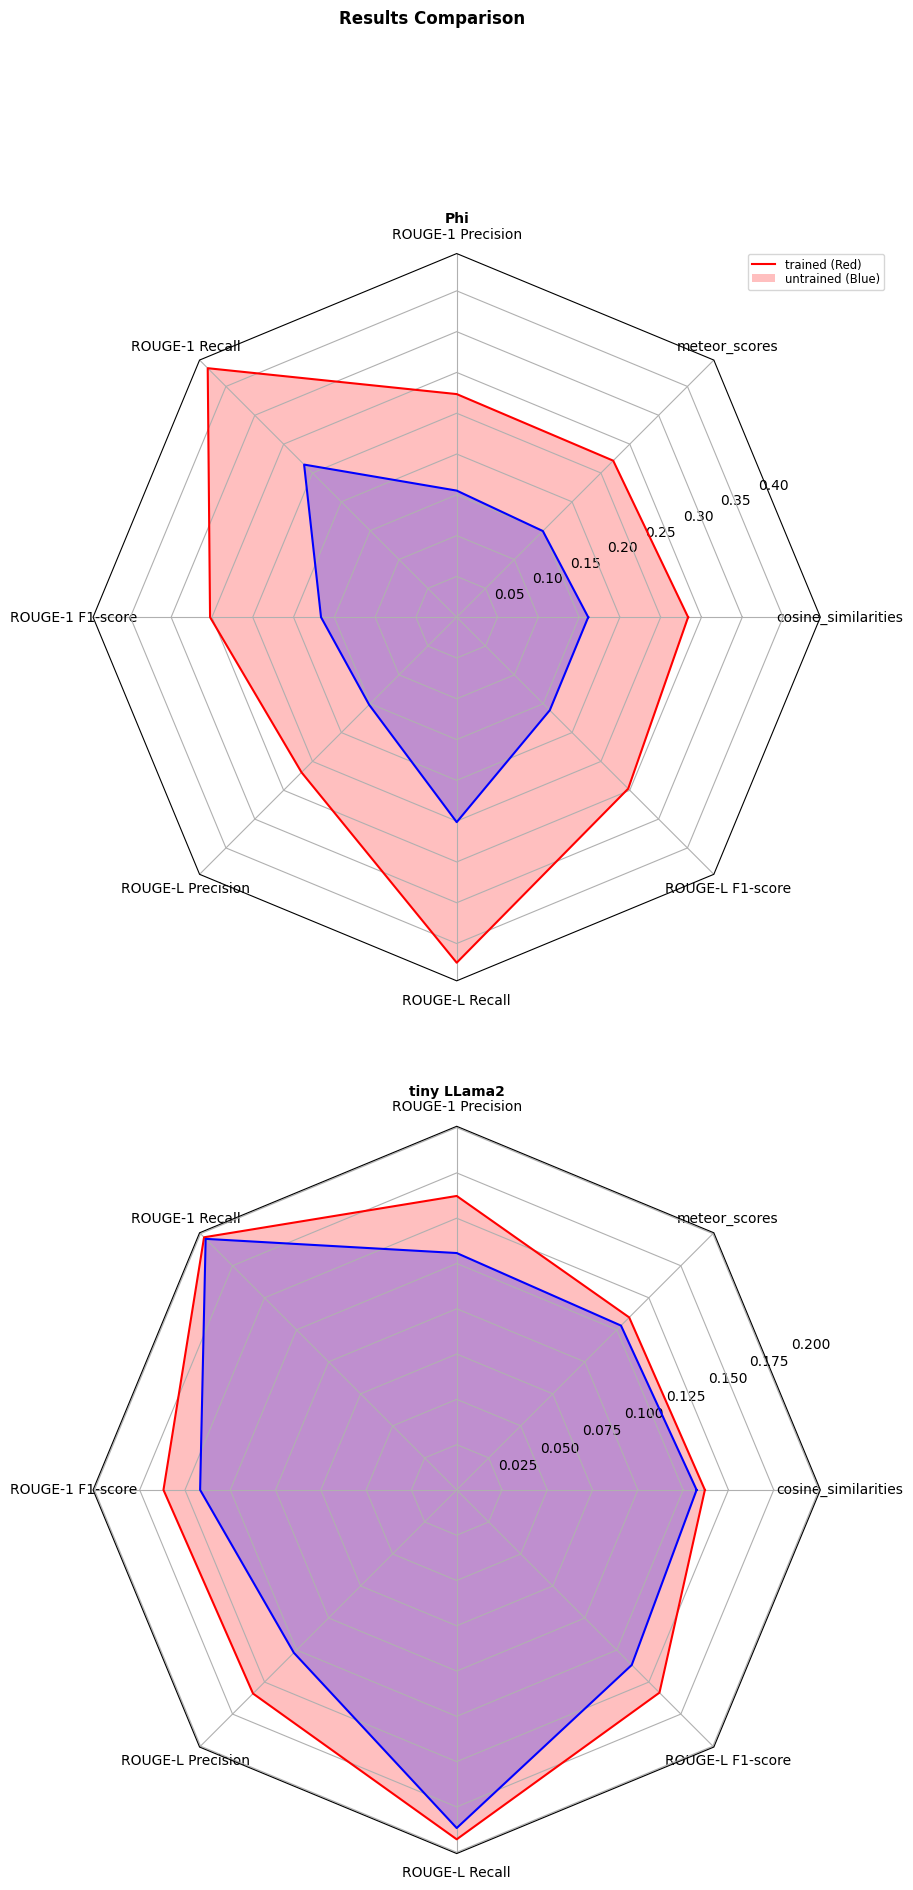

In [14]:
##[BEGIN][Reference][https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html]

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):
        name = 'radar'
        PolarTransform = RadarTransform

        def _init_(self, *args, **kwargs):
            super()._init_(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def extract_metrics(file_path):
    with open(file_path, 'r') as file:
        content = file.readlines()

    metrics = {}
    for line in content:
        parts = line.strip().split(':')
        if len(parts) == 2:
            metric_name = parts[0].strip()
            metric_value = float(parts[1].strip())
            metrics[metric_name] = metric_value
    return metrics


def example_data():
    root = './Evaluation_results/'
    m1 = extract_metrics(root+'/phi_trained_results.txt')
    m2 = extract_metrics(root+'/phi_untrained_results.txt')

    m3 = extract_metrics(root+'/tiny_llama_trained_results.txt')
    m4 = extract_metrics(root+'/tiny_llama_untrained_results.txt')

    data = [
        ['cosine_similarities', 'meteor_scores', 'ROUGE-1 Precision', 'ROUGE-1 Recall', 'ROUGE-1 F1-score', 'ROUGE-L Precision', 'ROUGE-L Recall', 'ROUGE-L F1-score'],
        ('Phi', [
            list(m1.values())[1:],
            list(m2.values())[1:]]),
        ('tiny LLama2', [
            list(m3.values())[1:],
            list(m4.values())[1:]]),
    ]
    return data


N = 8
theta = radar_factory(N, frame='polygon')

data = example_data()
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(20, 20), nrows=2, ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['r', 'b']
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='nolegend')
    ax.set_varlabels(spoke_labels)

labels = ('trained (Red)', 'untrained (Blue)')
legend = axs[0].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, 'Results Comparison',
            horizontalalignment='center', color='black', weight='bold',
            size='large')
plt.show()
#END[Reference]

## References

* https://www.datacamp.com/tutorial/fine-tuning-llama-2?irclickid=xc0ViaQ8xxyPWMp0gwwhE127UkHTF91m2Si00w0&irgwc=1&utm_medium=affiliate&utm_source=impact&utm_campaign=000000_1-2003851_2-mix_3-all_4-na_5-na_6-na_7-mp_8-affl-ip_9-na_10-bau_11-Bing%20Rebates%20by%20Microsoft&utm_content=BANNER&utm_term=EdgeBingFlow
* https://github.com/VenomZein/Chatbot-for-Q-A/blob/main/Q_A_chatbot.ipynb
* https://huggingface.co/datasets/saracandu/harry-potter-trivia-ai